# Quantum harmonic oscillator

This notebook solves for the eigenmodes of the quantum harmonic oscillator:

$$E \psi = - \frac{\hbar^2}{2 m} \partial_x^2 \psi + \frac{1}{2} m \omega^2 x^2 \psi$$

Non-dimensionalizing by setting $\hbar = m = \omega = 1$, we can rewrite this as:

$$2 E \psi + \partial_x^2 \psi - x^2 \psi = 0$$

We will use algebraically remapped (or rational) Chebyshev polynomails to solve over the whole real line (ref: Boyd ch. 17).

The mapping from $s \in [-1, 1]$ to $x \in [-\infty \infty]$ is

$$x = \frac{H s}{\sqrt{1 - s^2}}$$

With this mapping, derivatives become

$$\partial_x = \frac{\mathrm{d} s}{\mathrm{d} x} \partial_s = \frac{(1 - s^2)^{3/2}}{H} \partial_s$$

$$\begin{align}
\partial_x^2 &= \frac{(1 - s^2)^{3/2}}{H} \partial_s \left(\frac{(1 - s^2)^{3/2}}{H} \partial_s \right) \\
&= \frac{(1 - s^2)^3}{H^2} \partial_s^2 - 3 \frac{(1 - s^2)^{2}}{H^2} s \partial_s
\end{align}$$

Substituting the above change-of-variables, we have

$$2 E \psi + \frac{(1 - s^2)^3}{H^2} \partial_s^2 \psi - 3 \frac{(1 - s^2)^{2}}{H^2} s \partial_s \psi - \frac{H^2 s^2}{1 - s^2} \psi = 0$$

Clearing the denominators to get simple polynomial non-constant coefficients in $s$ gives us

$$2 H^2 (1 - s^2) E \psi + (1 - s^2)^4 \partial_s^2 \psi - 3 (1 - s^2)^{3} s \partial_s \psi - H^4 s^2 \psi = 0$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import logging
logging.getLogger().setLevel(logging.INFO)
%matplotlib notebook

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def qho_eigenmodes(N, H, m):
    """
    Solve quantum harmonic oscillator eigenmodes.
    
    Parameters
    ----------
    N : int
        Grid resolution
    H : float
        Remapping stretch factor
    m : int
        Number of eigenmodes
    """

    # Create bases and domain
    s_basis = de.Chebyshev('s', N, interval=(-1, 1))
    domain = de.Domain([s_basis], grid_dtype=np.complex128)
    
    # Quantum harmonic oscillator
    problem = de.EVP(domain, variables=['ψ','ψs'], eigenvalue='E')
    problem.meta[:]['s']['dirichlet'] = True
    problem.parameters['H'] = H
    problem.add_equation("2 * H**2 * (1-s**2) * E * ψ + (1-s**2)**4 * ds(ψs) - 3 * (1-s**2)**3 * s * ψs - H**4 * s**2 * ψ = 0")
    problem.add_equation("ψs - ds(ψ) = 0")
    problem.add_bc("left(ψ) = 0")
    problem.add_bc("right(ψ) = 0")
    
    # Solve sparse eigenvalue problem
    solver = problem.build_solver()
    solver.solve_sparse(solver.pencils[0], N=m, target=0)
    argsort = np.argsort(solver.eigenvalues.real)
    solver.eigenvalues = solver.eigenvalues[argsort]
    solver.eigenvectors = solver.eigenvectors[:, argsort]
    
    return domain, solver

## Plot some solutions

2018-03-19 19:42:56,750 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


<IPython.core.display.Javascript object>


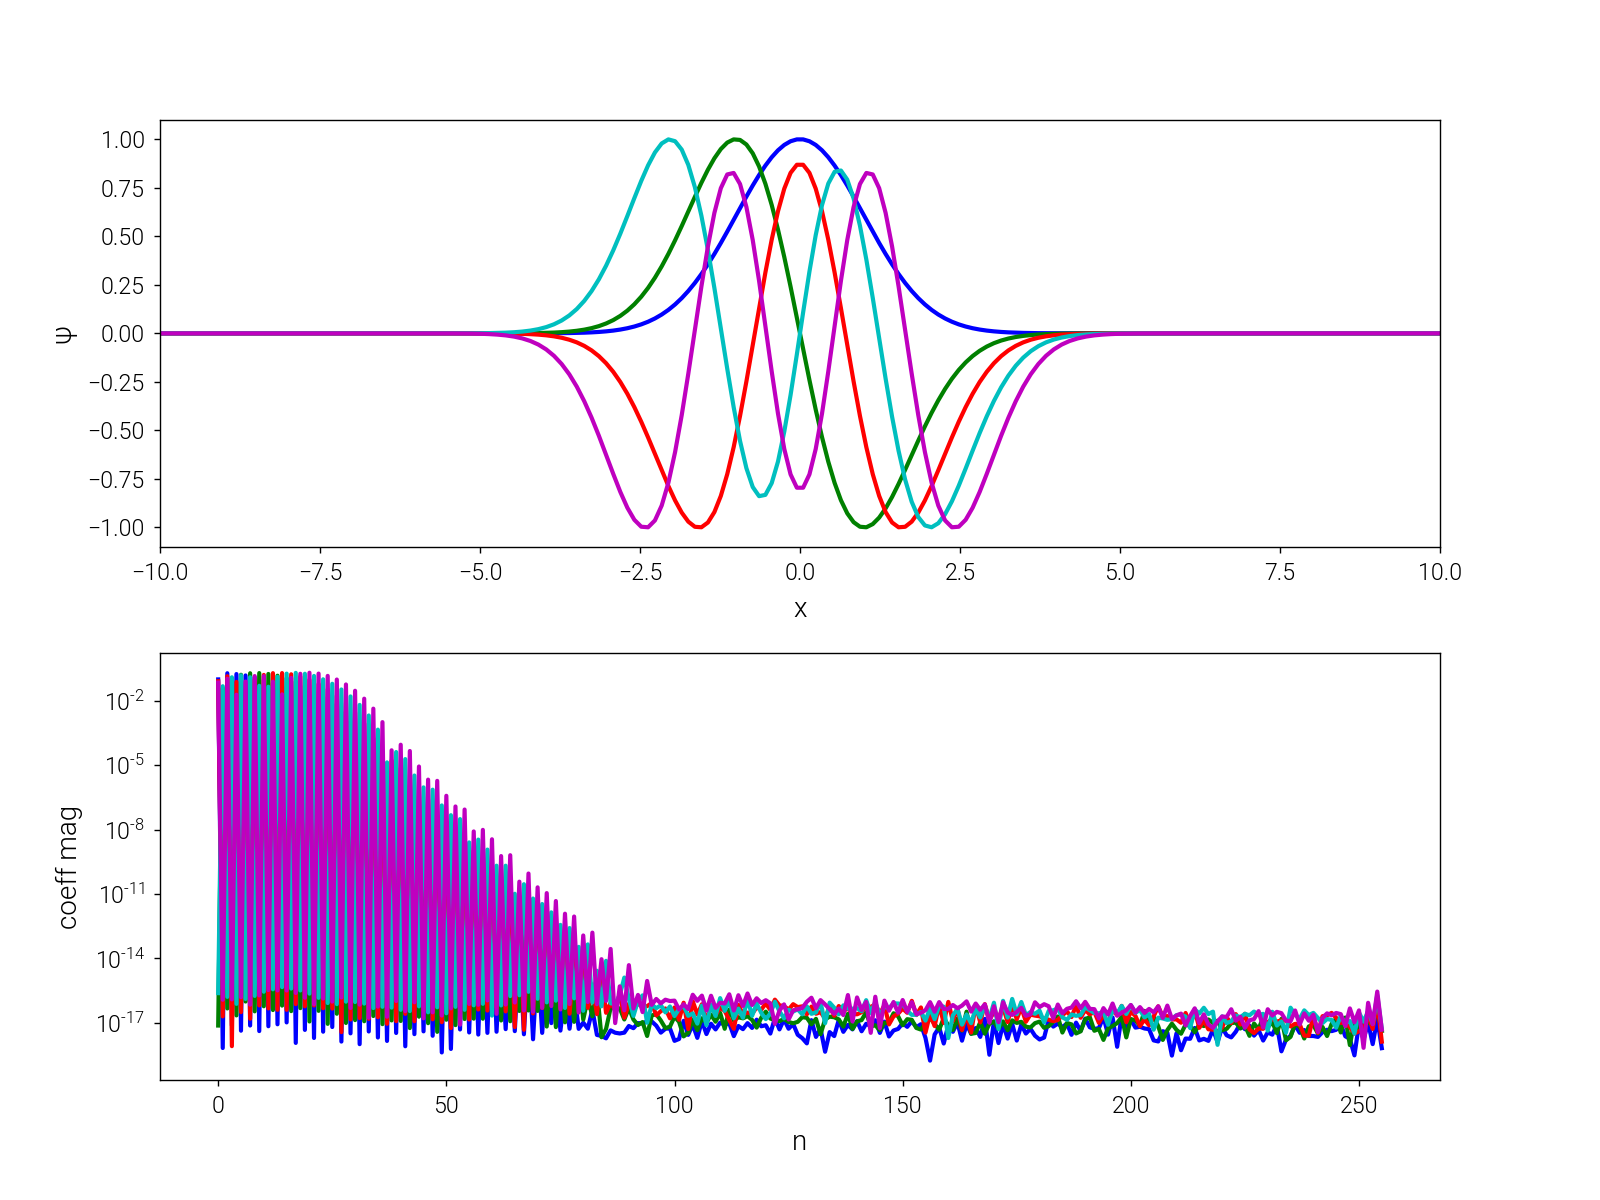

Text(0,0.5,'coeff mag')

In [3]:
# Parameters
N = 256
H = 8
m = 5

# Compute eigenmodes
domain, solver = qho_eigenmodes(N, H, m)
ψ = solver.state['ψ']
s = domain.grid(0)
x = H * s / np.sqrt(1 - s**2)

# Plot grid and coefficients
fix, (ax1, ax2) = plt.subplots(2, 1)
for i in range(m):
    solver.set_state(i)
    # Remove mean phase and renormalize
    phase = np.arctan(ψ['g'].imag/ψ['g'].real)
    phase = np.sum(phase*np.abs(ψ['g'])) / np.sum(np.abs(ψ['g']))
    ψ['g'] *= np.exp(-1j*phase)
    ψ['g'] /= np.max(np.abs(ψ['g']))
    ax1.plot(x, ψ['g'].real)
    ax2.semilogy(np.abs(ψ['c']))
ax1.set_xlim(-10, 10)
ax1.set_xlabel('x')
ax1.set_ylabel('ψ')
ax2.set_xlabel('n')
ax2.set_ylabel("coeff mag")

## Test eigenvalue error vs H

<IPython.core.display.Javascript object>


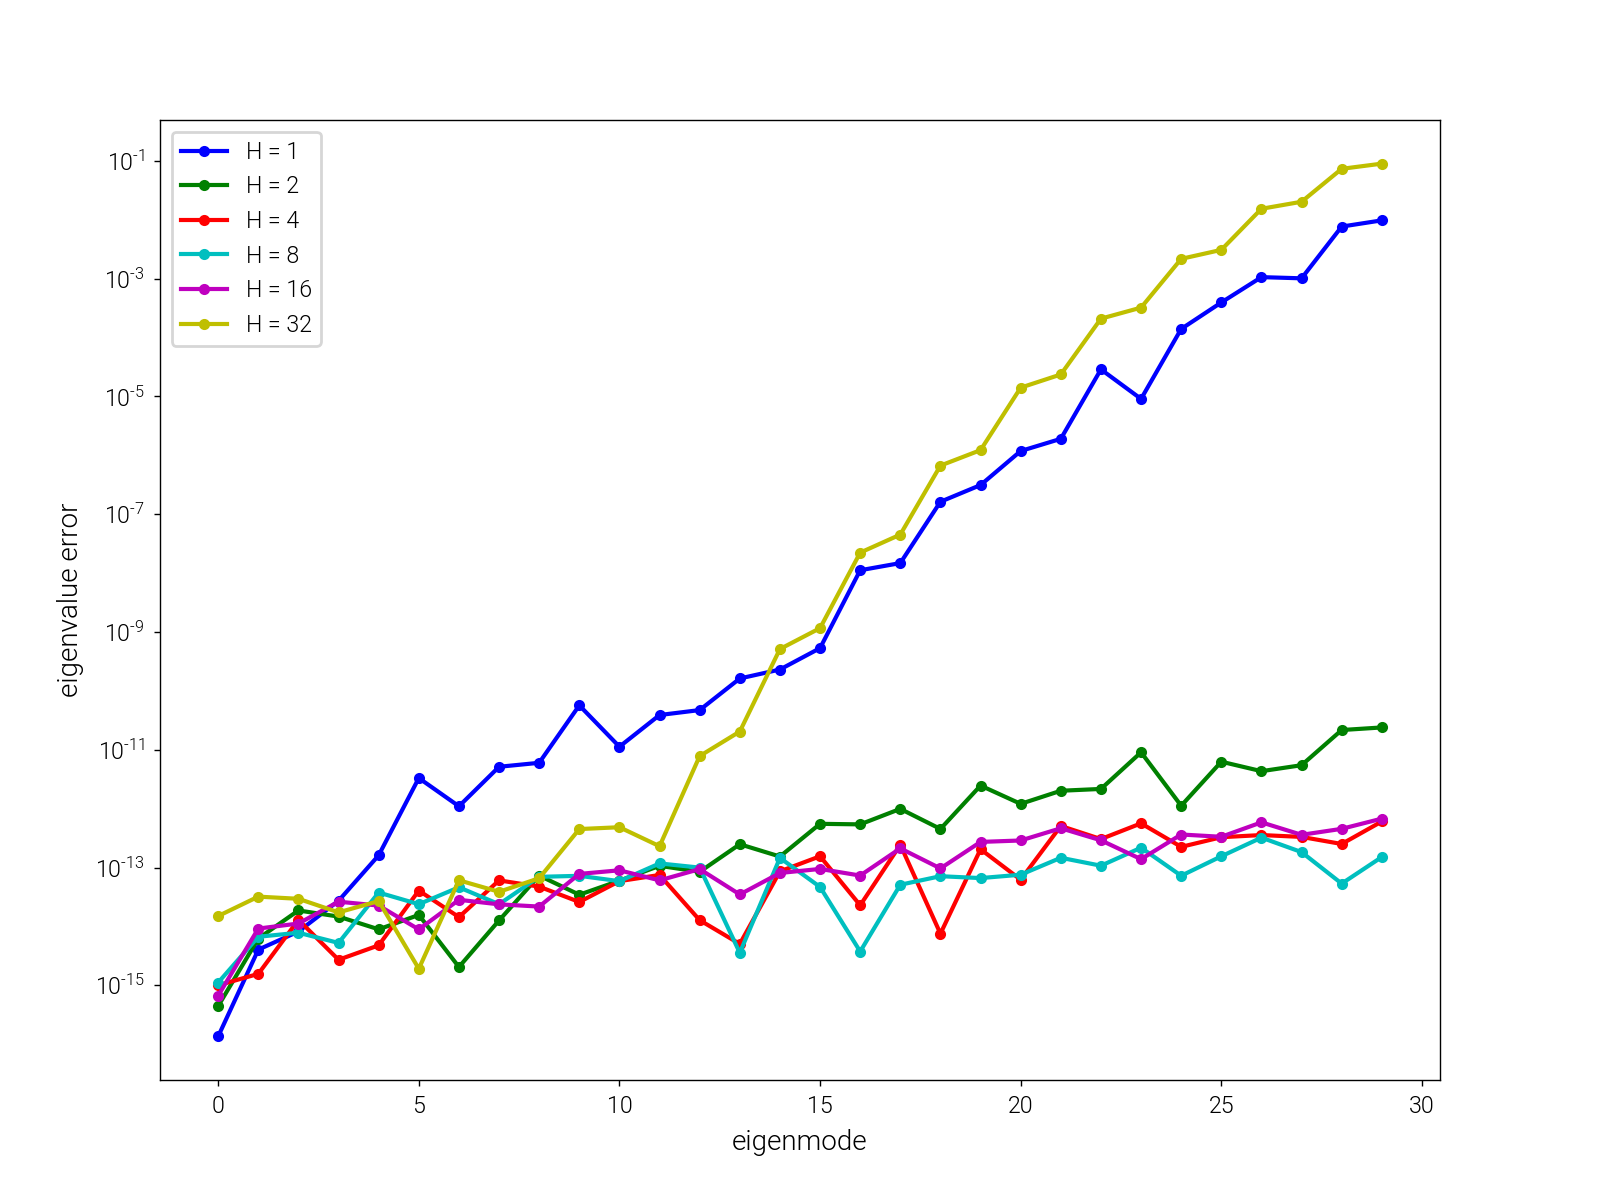

2018-03-19 19:42:57,118 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-03-19 19:42:57,450 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-03-19 19:42:57,726 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-03-19 19:42:58,009 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-03-19 19:42:58,298 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-03-19 19:42:58,579 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


Text(0,0.5,'eigenvalue error')

In [4]:
# Parameters
N = 256
H_list = [1, 2, 4, 8, 16, 32]
m = 30
true_eigenvalues = 0.5 + np.arange(m)

# Plot eigenvalue errors
plt.figure()
for H in H_list:
    domain, solver = qho_eigenmodes(N, H, m)
    error = np.abs(true_eigenvalues - solver.eigenvalues)
    plt.semilogy(error, '.-', label='H = %s' %H)
plt.legend(loc='upper left')
plt.xlabel('eigenmode')
plt.ylabel('eigenvalue error')